### Постороение модели для предсказания вероятности погашения кредита с просрочкой до 15 дней

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

C:\Users\Ale\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Предварительно в таблицу были добавлены релевантные столбцы, которые могут оказать влияние на срок погашения кредита. 

In [2]:
df = pd.read_csv('scoring_data.csv', sep=';')
df.head()

,al_ContractNumber,al_amount,al_issue_M_group,sex,is_client_local,has_snils,zaim_cards,age,has_foreign_currency_credits,court_counts,...,avg_payout_period_pdl,avg_pdl_full_cost,avg_pdl_amount,pdl_delay5_avg,pdl_delay30_avg,pdl_delay60_avg,pdl_delay90_avg,pdl_delay_more_avg,res_npl_15,is_test
0,882-001-17,3000.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1776-001-17,5000.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2234-001-17,5000.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2649-001-17,5000.0,1.0,2.0,1.0,1.0,0.0,3.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2320-001-17,3000.0,1.0,2.0,1.0,1.0,0.0,3.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


В данных удалены пустые строки, проверено отсутствие дубликатов и выбросов.

In [3]:
df.isna().sum()

al_ContractNumber               46
al_amount                       46
al_issue_M_group                46
sex                             46
is_client_local                 46
has_snils                       46
zaim_cards                      46
age                             46
has_foreign_currency_credits    46
court_counts                    46
official_count                  46
has_resold_credits              46
cred_line_state                 46
potreb_tot                      46
potreb_active_tot_group         46
potreb_other_states_tot         46
pdl_tot                         46
pdl_closed_tot                  46
pdl_active_to_total_group       46
pdl_delay5_cnt                  46
pdl_delay30_cnt                 46
pdl_delay60_cnt                 46
pdl_delay90_cnt                 46
pdl_delay_more_cnt              46
pdl_prolong_cnt                 46
avg_payout_period_pdl           46
avg_pdl_full_cost               46
avg_pdl_amount                  46
pdl_delay5_avg      

In [4]:
df = df.dropna()

In [5]:
df.duplicated().sum()

0

<ipython-input-6-3c1ba25788f9>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=ax)


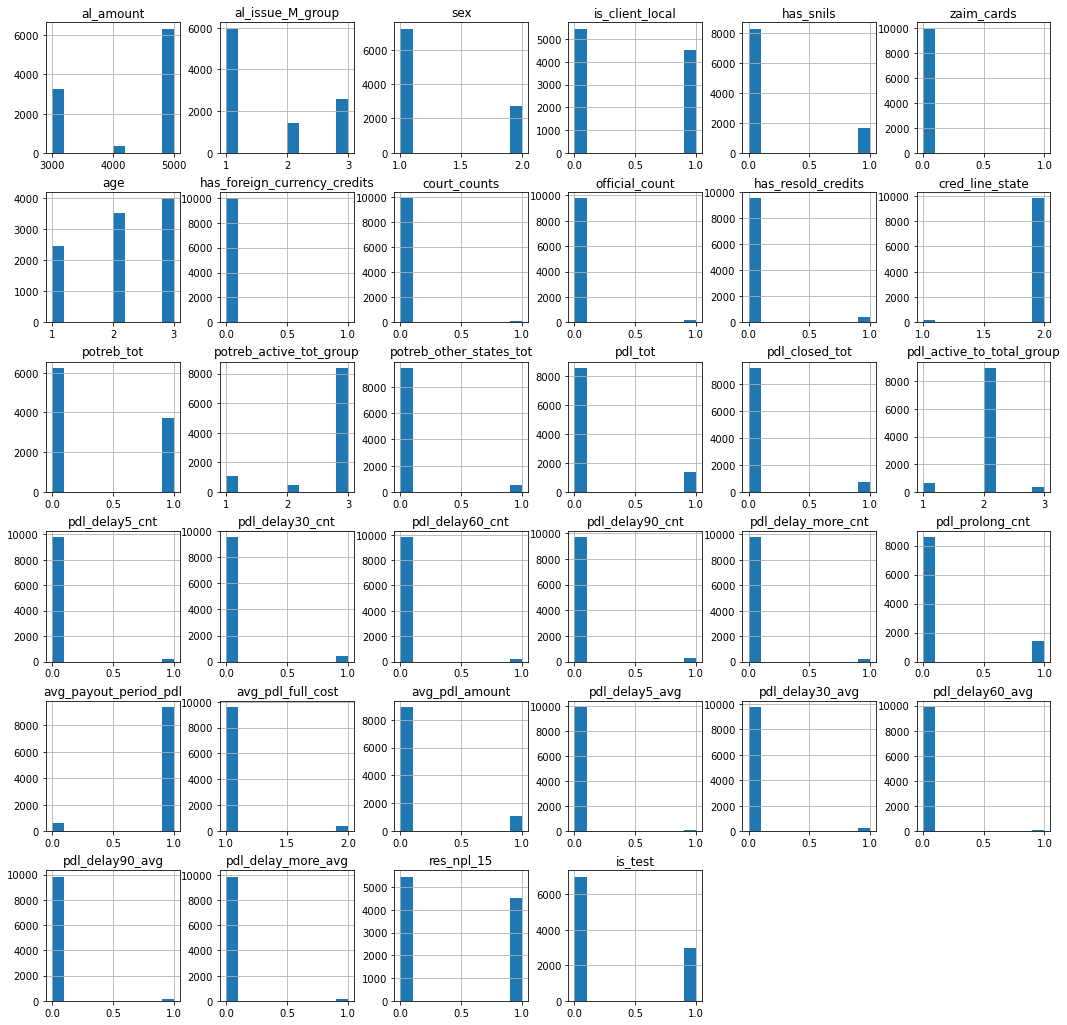

In [6]:
fig = plt.figure(figsize = (18,18))
ax = fig.gca()
df.hist(ax=ax)
plt.show()

Для постороения модели нормализованы данные посредством масштабирования.

In [7]:
headers = list(df.iloc[:,1:35].columns.values)

In [8]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
np_scaled = min_max_scaler.fit_transform(df.iloc[:,1:35])
all_data_scaling = pd.DataFrame(np_scaled)

In [9]:
all_data_scaling.columns = headers
all_data_scaling

,al_amount,al_issue_M_group,sex,is_client_local,has_snils,zaim_cards,age,has_foreign_currency_credits,court_counts,official_count,...,avg_payout_period_pdl,avg_pdl_full_cost,avg_pdl_amount,pdl_delay5_avg,pdl_delay30_avg,pdl_delay60_avg,pdl_delay90_avg,pdl_delay_more_avg,res_npl_15,is_test
0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,0.5,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9979,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9980,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9981,1.0,0.0,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Данные были разделены на тестовую и обучающую выборку.

In [10]:
df_train = all_data_scaling[all_data_scaling['is_test']==0]
y_train = df_train['res_npl_15']
X_train = df_train.drop(['res_npl_15', 'is_test'], axis = 1) 
df_test = all_data_scaling[all_data_scaling['is_test']==1]
y_test = df_test['res_npl_15']
X_test = df_test.drop(['res_npl_15', 'is_test'], axis = 1) 

Для сравнения подобраны 5 классификаторов для постороения предсказательной модели.

In [11]:
models = []
models.append(LogisticRegression())
models.append(RandomForestClassifier(n_estimators=170, max_depth=4, criterion='entropy'))
models.append(GradientBoostingClassifier(max_depth =4))
models.append(KNeighborsClassifier(n_neighbors=20))
models.append(GaussianNB())

Модели обучены и проверены на точность, полноту и агрегированный критерий качества.

In [12]:
for index, model in enumerate(models):
    model.fit(X_train, y_train)
    df_pred = model.predict(X_test)
    names = ['LogRegression', 'RandomForest', 'GradBooosting', 'KNeighbors', 'Gaussian'] 
    precision = precision_score(y_test, df_pred)
    print(f"\nThe precision score for {names[index]} is: {round(precision,3)*100}%")
    recall = recall_score(y_test, df_pred)
    print(f"The recall score for {names[index]} is: {round(recall,3)*100}%")
    f1 = f1_score(y_test, df_pred)
    print(f"The f1 score for {names[index]} is: {round(f1,3)*100}%")


The precision score for LogRegression is: 60.9%
The recall score for LogRegression is: 62.9%
The f1 score for LogRegression is: 61.8%

The precision score for RandomForest is: 59.099999999999994%
The recall score for RandomForest is: 77.9%
The f1 score for RandomForest is: 67.2%

The precision score for GradBooosting is: 62.2%
The recall score for GradBooosting is: 64.3%
The f1 score for GradBooosting is: 63.2%

The precision score for KNeighbors is: 60.0%
The recall score for KNeighbors is: 60.9%
The f1 score for KNeighbors is: 60.5%

The precision score for Gaussian is: 50.8%
The recall score for Gaussian is: 90.4%
The f1 score for Gaussian is: 65.10000000000001%


Выбор предсказательной модели зависит от задачей организации. 
* Если для кредитной организации дорого обходятся риски выдачи кредита заемщику, который погасит его с просрочкой, то нужно ориентироваться на метрику recall(полнота), чем она больше, тем больше хороших заемщиков модель обнаружила. В таком случае рекомендую модель наивного байесовского классификатора (GaussianNB).
* Если кредитная организация не несет сильных потерь, если выдаст кредит плохому заемщику, а наоборот получит больше прибыли, если раздаст большее количество кредитов, то нужно ориентироваться на метрику precision(точность). Precision показывает, насколько хороша наша модель в том, чтобы не выдвигать ложных обвинений, то есть какая доля заемщиков, для которых модель предсказала отсутствие просрочки, действительно выплатят кредит без просрочки. В таком случае рекомендую модель градиентного бустинга (GradientBoostingClassifier).
* Если бизнес затрудняется определиться с задачами, следует ориентироваться на метрику f1-score(агрегированный критерий качества), которая объединяет информацию о точности и полноте классификатра, придавая им одинаковый вес. В таком случае рекомендую модель случайного леса (RandomForest).

Создана таблица с исходными данными и предсказанной вероятностью погашения кредита с просрочкой до 15 дней, где 1 означает, что клиент погасит кредит без просрочки с вероятностью более 50%, а 0 - клиент погасит кредит без просрочки с вероятностью менее 50%. В зависимости от задач бизнеса нужно ориентироваться на прогноз одной из двух моделей.

In [13]:
test= pd.DataFrame(columns=['pred_Gaussian', 'pred_GradBooosting'])
test['pred_Gaussian']= models[4].fit(X_train, y_train).predict(X_test)
test['pred_GradBooosting']= models[2].fit(X_train, y_train).predict(X_test)
test['pred_RandomForest']= models[1].fit(X_train, y_train).predict(X_test)
result_df = pd.concat([df[df['is_test']==1].reset_index(drop=True), test.reset_index(drop=True)], axis=1)
result_df

,al_ContractNumber,al_amount,al_issue_M_group,sex,is_client_local,has_snils,zaim_cards,age,has_foreign_currency_credits,court_counts,...,pdl_delay5_avg,pdl_delay30_avg,pdl_delay60_avg,pdl_delay90_avg,pdl_delay_more_avg,res_npl_15,is_test,pred_Gaussian,pred_GradBooosting,pred_RandomForest
0,116913-082-17,5000.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1,117152-082-17,5000.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2,118448-082-17,5000.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,119301-082-17,3000.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,119994-082-17,3000.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981,80519-128-17,4000.0,1.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2982,82024-128-17,3000.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2983,82115-128-17,3000.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2984,84064-128-17,5000.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Данные модели имеют невысокую точность, это связано со слабокоррелирующими показателями с таргетной переменной в данных. Для более точного прогноза погашения кредита без просрочки требуется больше коррелирующих данных, например скоринговый балл по данным из БКИ, уровень дохода и образования.